# Projeto Final de SBC

> Este notebook está organizado em seções navegáveis.

Implementação e treinamento de um Transformer e Modelo Oculto de Markov para "dada uma frase, complete onde há a máscara com base em algo que um dos personagens da série de TV Friends responderia".

**Grupo** Mayra Daher e Samantha Medeiros.

## Sobre os dados e a implementação
A base de dados utilizada são as falas dos 6 personagens principais da série, cada um possuindo seu próprio arquivo `.txt` com todas as frases ditas por eles ao longo da série. A base de dados completa pode ser acessada no seguinte **[Dataset Kaggle](https://www.kaggle.com/datasets/blessondensil294/friends-tv-series-screenplay-script)**.

## Como executar este notebook?
1. Baixe as dependências;
2. Execute cada uma das células de código;
3. E execute o bloco de código da seção "Main".

## Importante se atentar
- Se estiver utilizando o ambiente Google Colab, certifique-se de executar a célular correspondente;
- Verifique se o caminho dos arquivos;
- Certique-se de que todos os arquivos necessários para a execução deste notebook estejam presentes.

## Referências
1. [Jonathan Hui. Speech Recognition - GMM, HMMM](https://jonathan-hui.medium.com/speech-recognition-gmm-hmm-8bb5eff8b196)
2. [Ankur Singh. End-to-end Masked Language Modeling with BERT](https://keras.io/examples/nlp/masked_language_modeling/#create)

# **Implementação BERT** (parte 1)

## BERT model (Pretraining Model)

### Dependências

In [ ]:
#setup de ambiente
!pip install -q keras-nlp tensorflow tensorflow-hub

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import keras_nlp
from google.colab import files
import numpy as np
import os
import re


os.makedirs("checkpoints", exist_ok=True)

### Carregando Base de Dados

In [ ]:
#uploado manual das legendas
uploaded = files.upload()

Saving S01E01 Monica Gets A Roommate.txt to S01E01 Monica Gets A Roommate.txt
Saving S01E02 The Sonogram At The End.txt to S01E02 The Sonogram At The End.txt
Saving S01E03 The Thumb.txt to S01E03 The Thumb.txt
Saving S01E04 George Stephanopoulos.txt to S01E04 George Stephanopoulos.txt
Saving S01E05 The East German Laundry Detergent.txt to S01E05 The East German Laundry Detergent.txt
Saving S01E06 The Butt.txt to S01E06 The Butt.txt
Saving S01E07 The Blackout.txt to S01E07 The Blackout.txt
Saving S01E08 Nana Dies Twice.txt to S01E08 Nana Dies Twice.txt
Saving S01E09 Underdog Gets Away.txt to S01E09 Underdog Gets Away.txt
Saving S01E10 The Monkey.txt to S01E10 The Monkey.txt
Saving S01E11 Mrs. Bing.txt to S01E11 Mrs. Bing.txt
Saving S01E12 The Dozen Lasagnas.txt to S01E12 The Dozen Lasagnas.txt
Saving S01E13 The Boobies.txt to S01E13 The Boobies.txt
Saving S01E14 The Candy Hearts.txt to S01E14 The Candy Hearts.txt
Saving S01E15 The Stoned Guy.txt to S01E15 The Stoned Guy.txt
Saving S01E1

### Extração de Falas por Personagem

In [ ]:
#Leitura e Extração das Falas dos Arquivos .txt

import os
import re

#Resetar as variáveis
personagens_principais = ["phoebe", "chandler", "rachel", "monica", "ross", "joey"]
falas_por_personagem = {nome.upper(): [] for nome in personagens_principais}

arquivos_legendas = sorted([f for f in os.listdir("/content") if f.endswith(".txt")])

for nome_arquivo in arquivos_legendas:
    with open(nome_arquivo, "r", encoding="utf-8") as f:
        for linha in f:
            linha = linha.strip()

            for personagem in personagens_principais:
                if linha.lower().startswith(personagem + ":"):
                    fala = linha.split(":", 1)[1].strip()
                    fala = re.sub(r"\([^)]*\)", "", fala)  # remove parênteses
                    fala = fala.lower()
                    if fala:
                        falas_por_personagem[personagem.upper()].append(fala)



In [ ]:
print("Personagens disponíveis em falas_por_personagem:")
print(falas_por_personagem.keys())

Personagens disponíveis em falas_por_personagem:
dict_keys(['PHOEBE', 'CHANDLER', 'RACHEL', 'MONICA', 'ROSS', 'JOEY'])


In [ ]:
#Exibir algumas falas de Joey como exemplo
print("falas do RACHEL:")
for fala in falas_por_personagem["RACHEL"][:10]:
    print("-", fala)

falas do RACHEL:
- oh god monica hi! thank god! i just went to your building and you weren't there and then this guy with a big hammer said you might be here and you are, you are!
- hi, sure!
- oh god... well, it started about a half hour before the wedding. i was in the room where we were keeping all the presents, and i was looking at this gravy boat. this really gorgeous lamauge gravy boat. when all of a sudden- sweet 'n' lo?- i realized that i was more turned on by this gravy boat than by barry! and then i got really freaked out, and that's when it hit me: how much barry looks like mr. potato head. y'know, i mean, i always knew looked familiar, but... anyway, i just had to get out of there, and i started wondering 'why am i doing this, and who am i doing this for?'.  so anyway i just didn't know where to go, and i know that you and i have kinda drifted apart, but you're the only person i knew who lived here in the city.
- ooh, i was kinda hoping that wouldn't be an issue... [scene: 

### Análise Exploratória da Base de Dados

Distribuição de falas por personagem:
   PHOEBE: 7389 falas
 CHANDLER: 8381 falas
   RACHEL: 9142 falas
   MONICA: 8310 falas
     ROSS: 9099 falas
     JOEY: 8210 falas


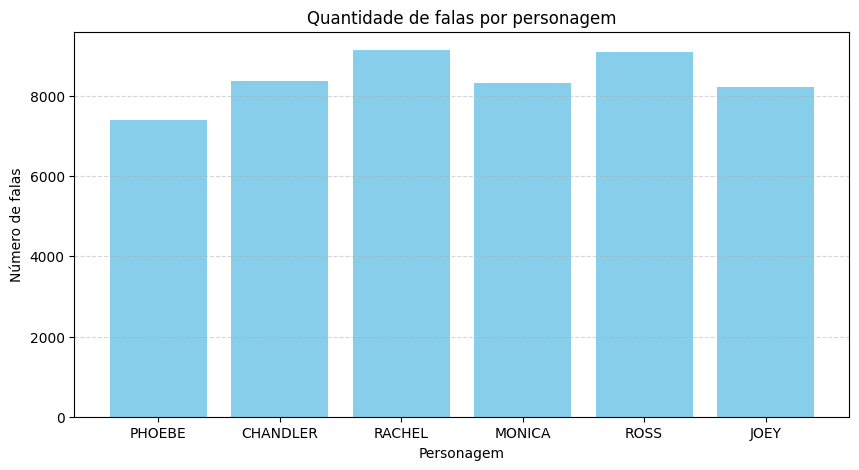

In [ ]:
#Análise de Quantidade de Falas por Personagem

import matplotlib.pyplot as plt

#listas
nomes = list(falas_por_personagem.keys())
quantidades = [len(falas_por_personagem[nome]) for nome in nomes]

#Exibe em texto
print("Distribuição de falas por personagem:")
for nome, qtd in zip(nomes, quantidades):
    print(f"{nome:>9}: {qtd} falas")

#gráfico
plt.figure(figsize=(10, 5))
plt.bar(nomes, quantidades, color='skyblue')
plt.title("Quantidade de falas por personagem")
plt.xlabel("Personagem")
plt.ylabel("Número de falas")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [ ]:
#Adicionar a tag [PERSONAGEM] no início de cada fala

#lista única com a tag do personagem
falas_tagged = []

for personagem, falas in falas_por_personagem.items():
    for fala in falas:
        falas_tagged.append(f"[{personagem}] {fala}")

print(f"Total de falas tagueadas: {len(falas_tagged)}")
print("Exemplo de falas com tags:")
for fala in falas_tagged[:6]:
    print("-", fala)

Total de falas tagueadas: 50531
Exemplo de falas com tags:
- [PHOEBE] wait, does he eat chalk?
- [PHOEBE] just, 'cause, i don't want her to go through what i went through with carl- oh!
- [PHOEBE] no.
- [PHOEBE] ooh! oh! 
- [PHOEBE] fine!  be murky!
- [PHOEBE] if i let go of my hair, my head will fall off.


In [ ]:
#NÃO EXECUTAR
#Aplicando oversampling para equilibrar o número de falas

from random import choices, shuffle

#Tamanho da maior classe
tamanho_maximo = max(len(falas) for falas in falas_por_personagem.values())
print(f"Todas as classes serão aumentadas para {tamanho_maximo} falas.")

#Lista final com as falas balanceadas
falas_balanceadas = []

#oversampling
for personagem, falas in falas_por_personagem.items():
    falas_expandida = choices(falas, k=tamanho_maximo)
    falas_tagged = [f"[{personagem}] {fala}" for fala in falas_expandida]
    falas_balanceadas.extend(falas_tagged)


shuffle(falas_balanceadas)

print(f"Total de falas no dataset final: {len(falas_balanceadas)}")
print("Exemplos de falas balanceadas:")
for fala in falas_balanceadas[:6]:
    print("-", fala)

Todas as classes serão aumentadas para 18284 falas.
Total de falas no dataset final: 109704
Exemplos de falas balanceadas:
- [CHANDLER]  wow! listen, we had a good run. what was it? four? five months? i mean, that's more than most people have in a lifetime! so, good-bye, take care, bye-bye then! 
- [CHANDLER] hey man, what's up?
- [PHOEBE] oh can i? vegetarians never get to do the wishbone. it's really not fair either! you know, just because we don't eat the meat doesn't mean we don't like to play with the carcasses!
- [JOEY] check it out, giants-cowboys. 
- [CHANDLER]  i don't, and i'm offended by the insinuation!
- [MONICA] okay!


In [ ]:
#NÃO EXECUTAR
#Salvar o dataset balanceado (falas_balanceadas)
with open("falas_balanceadas.txt", "w", encoding="utf-8") as f:
    for linha in falas_balanceadas:
        f.write(linha + "\n")

# Fazer o download do arquivo para o computador
from google.colab import files
files.download("falas_balanceadas.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Salvar o dataset
with open("falas_tagged.txt", "w", encoding="utf-8") as f:
    for linha in falas_tagged:
        f.write(linha + "\n")

#Fazer o download do arquivo para o computador
from google.colab import files
files.download("falas_tagged.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TextVectorizer - Vetorização do texto em IDs de Tokens

Vamos usar TextVectorization layer para vetorizar o texto em tokens ids

In [ ]:
# criar a vectorize_layer incluindo o token especial [MASK]
texts = falas_tagged

# normalização
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    clean_text = tf.strings.regex_replace(lowercase, r"[^\w\s\[\]]", "")  # mantém colchetes
    return clean_text

#criação da vectorize_layer
def get_vectorize_layer(texts, vocab_size=30000, max_seq_length=128, special_tokens=["[MASK]"]):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq_length,
    )
    vectorize_layer.adapt(texts)

    # Ajuste do vocabulário
    vocab = vectorize_layer.get_vocabulary()
    vocab = [tok for tok in vocab if tok not in ["", "[UNK]"] + special_tokens]
    vocab = vocab[:vocab_size - len(special_tokens) - 2]
    vocab_final = ["", "[UNK]"] + special_tokens + vocab
    vectorize_layer.set_vocabulary(vocab_final)

    # Envolve em um modelo Keras e salva
    vectorize_model = keras.Sequential([vectorize_layer])
    vectorize_model(tf.constant(["exemplo de frase"]))  # força a construção

    path = "vectorize_layer_model.keras"
    vectorize_model.save(path)
    #files.download(path)

    return vectorize_layer



In [ ]:
#criar a camada com os textos:
vectorize_layer = get_vectorize_layer(falas_tagged)
vocab = vectorize_layer.get_vocabulary()

#Cria os dicionários
id2token = dict(enumerate(vocab))
token2id = {token: idx for idx, token in enumerate(vocab)}

#Pega o ID do token [MASK]
if "[MASK]" not in token2id:
    raise ValueError("[MASK] token não está no vocabulário!")

mask_token_id = token2id["[MASK]"]
print("ID do token [MASK]:", mask_token_id)

ID do token [MASK]: 2


In [ ]:
# Empacotar a camada em um modelo
vectorize_model = keras.Sequential([vectorize_layer])

# Executar uma previsão exemplo para construir o modelo
vectorize_model(tf.constant(["exemplo de texto"]))

# Salvar o modelo em disco
vectorize_model.save("vectorize_layer_model.keras")

# Fazer o download para o computador
files.download("vectorize_layer_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Aplica a vetorização nas falas
def encode(texts, vectorize_layer):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

### BERT-Style Masking

In [ ]:
#Função para aplicar o BERT-style masking
def get_masked_input_and_labels(encoded_texts, mask_token_id):
    # 15% de probabilidade para máscara
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15

    # Não mascara tokens especiais (ID 0 = padding, 1 = OOV, 2 = MASK)
    inp_mask[encoded_texts <= 2] = False

    # Labels: -1 nos tokens que não serão previstos
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    labels[inp_mask] = encoded_texts[inp_mask]

    # Cópia da entrada original para aplicar modificações
    encoded_texts_masked = np.copy(encoded_texts)

    # 90% dos tokens selecionados viram [MASK]
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[inp_mask_2mask] = mask_token_id

    # 10% viram tokens aleatórios
    inp_mask_2random = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.10)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, len(vectorize_layer.get_vocabulary()), inp_mask_2random.sum()
    )

    # Pesos: só computa loss onde o label não é -1
    sample_weights = np.ones(labels.shape, dtype=np.float32)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

In [ ]:
#Codifica os textos
x_all_encoded = encode(falas_tagged, vectorize_layer)

#aplica o masking
x_masked, y_labels, sample_weights = get_masked_input_and_labels(
    x_all_encoded, mask_token_id
)

#Cria o dataset final
mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked, y_labels, sample_weights)
).shuffle(1000).batch(32)

In [ ]:
#Visualiza uma amostra do dataset
for batch in mlm_ds.take(1):
    input_ids, labels, weights = batch
    print("Entrada (com [MASK]):", input_ids[0].numpy())
    print("Rótulos corretos     :", labels[0].numpy())
    print("Pesos (sample_weights):", weights[0].numpy())

Entrada (com [MASK]): [  14    4   35    7    2 2401    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Rótulos corretos     : [  14    4   35    7  778 2401    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0

### Modelagem BERT

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Hiperparâmetros
EMBED_DIM = 128
NUM_HEAD = 4
FF_DIM = 256
NUM_LAYERS = 4
VOCAB_SIZE = 30000
MAX_LEN = 128
LR = 1e-4

#criar um bloco BERT
def bert_module(query, key, value, i):
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEAD,
        key_dim=EMBED_DIM // NUM_HEAD,
        name=f"encoder_{i}_multiheadattention"
    )(query, key, value)

    attention_output = layers.Dropout(0.1, name=f"encoder_{i}_att_dropout")(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-4, name=f"encoder_{i}_att_layernormalization")(query + attention_output)

    ffn = keras.Sequential([
        layers.Dense(FF_DIM, activation="relu"),
        layers.Dense(EMBED_DIM)
    ], name=f"encoder_{i}_ffn")

    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}_ffn_dropout")(ffn_output)
    output = layers.LayerNormalization(epsilon=1e-4, name=f"encoder_{i}_ffn_layernormalization")(attention_output + ffn_output)

    return output


In [ ]:
#Função de perda e métrica
loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction="none")
loss_tracker = keras.metrics.Mean(name="loss")

#Modelo de linguagem mascarada
class MaskedLanguageModel(keras.Model):
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        loss = loss_fn(y, y_pred, sample_weight)
        loss_tracker.update_state(loss, sample_weight=sample_weight)
        return tf.reduce_sum(loss)

    def compute_metrics(self, x, y, y_pred, sample_weight):
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

In [ ]:
#Monta o Modelo BERT para MLM
import keras_nlp

def create_masked_language_bert_model():
    inputs = layers.Input(shape=(MAX_LEN,), dtype="int64", name="input_ids")

    # Word embeddings
    word_embeddings = layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_DIM,
        name="word_embedding"
    )(inputs)

    # Positional embeddings
    position_embeddings = keras_nlp.layers.PositionEmbedding(
        sequence_length=MAX_LEN,
        name="position_embedding"
    )(word_embeddings)

    # Soma dos embeddings
    embeddings = word_embeddings + position_embeddings

    # Encoder BERT
    x = embeddings
    for i in range(NUM_LAYERS):
        x = bert_module(x, x, x, i)

    # MLM head
    outputs = layers.Dense(VOCAB_SIZE, activation="softmax", name="mlm_cls")(x)

    # Modelo final
    model = MaskedLanguageModel(inputs, outputs, name="friends_masked_bert_model")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))

    return model

In [ ]:
#mlm_ds com os tensores
mlm_ds = tf.data.Dataset.from_tensor_slices((x_masked, y_labels, sample_weights))
mlm_ds = mlm_ds.shuffle(1000).batch(32)

In [ ]:
#Cria o modelo e salva
from google.colab import files


mlm_model = create_masked_language_bert_model()
mlm_model.save("bert_mlm_friends.keras")

#Faz download do arquivo
files.download("bert_mlm_friends.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Treinamento do Modelo BERT

In [ ]:
#Treinamento do modelo com checkpoint baseado em loss
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import files

# Recarrega o modelo salvo
mlm_model = keras.models.load_model(
    "bert_mlm_friends.keras",
    custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)

# Converte os dados para os tipos corretos
x_masked = x_masked.astype("int32")
y_labels = y_labels.astype("int32")
sample_weights = np.ones(y_labels.shape, dtype=np.float32)
sample_weights[y_labels == -1] = 0

# Cria o dataset final para treinamento
dataset = tf.data.Dataset.from_tensor_slices(
    (x_masked, y_labels, sample_weights)
).shuffle(1000).batch(32)

# Callback para salvar o melhor modelo baseado no menor loss
checkpoint_cb = ModelCheckpoint(
    filepath="checkpoints/bert_mlm_best.keras",
    monitor="loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Treinamento do modelo
history = mlm_model.fit(
    dataset,
    epochs=5,
    callbacks=[checkpoint_cb]
)

# Salva o modelo final (última época)
mlm_model.save("bert_mlm_friends_trained.keras")

# Baixa os arquivos para o seu computador
files.download("bert_mlm_friends_trained.keras")
files.download("checkpoints/bert_mlm_best.keras")


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 138 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.7310
Epoch 1: loss improved from inf to 1.60996, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - loss: 3.7297
Epoch 2/5
1575/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2968
Epoch 2: loss improved from 1.60996 to 0.24415, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2966
Epoch 3/5
1576/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1813
Epoch 3: loss improved from 0.24415 to 0.16393, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.1813
Epoch 4/5
1576/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1427
Epoch 4: loss improved from 0.16393 to 0.13262, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.1427
Epoch 5/5
1576/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1218
Epoch 5: loss improved from 0.13262 to 0.1140

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Fine-tuning para Classificação de Personagem

In [ ]:
!pip install -q tensorflow keras-nlp

In [ ]:
#Carregar modelo pré-treinado
mlm_model = keras.models.load_model(
    "bert_mlm_friends.keras",
    custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)

#Extrai a base BERT até a última camada de encoder
pretrained_bert_model = keras.Model(
    mlm_model.input,
    mlm_model.get_layer("encoder_3_ffn_layernormalization").output
)

#Congela os pesos da BERT
pretrained_bert_model.trainable = False

#Cria o classificador
def create_classifier_bert_model():
    inputs = keras.Input(shape=(MAX_LEN,), dtype="int64")
    x = pretrained_bert_model(inputs)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(6, activation="softmax")(x)  #6 classes (6 personagens)

    model = keras.Model(inputs, outputs, name="friends_classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

#Instancia o classificador
classifier_model = create_classifier_bert_model()
classifier_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 138 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "friends_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_38 (Functional)      │ (None, 128, 128)       │     4,386,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,394,950 (16.77 MB)

 Trainable params: 8,646 (33.77 KB)

 Non-trainable params: 4,386,304 (16.73 MB)

### Preparar os datasets e pesos

In [ ]:
#Preparar os datasets e pesos

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
import tensorflow as tf
import re

# Mapeamento
personagem2id = {
    "[PHOEBE]": 0,
    "[CHANDLER]": 1,
    "[RACHEL]": 2,
    "[MONICA]": 3,
    "[ROSS]": 4,
    "[JOEY]": 5,
}

#Extrai textos e rótulos
textos = falas_tagged
rotulos = [personagem2id[re.search(r"\[(.*?)\]", linha).group()] for linha in textos]

# Divide em treino e teste
x_train, x_test, y_train, y_test = train_test_split(
    textos, rotulos, test_size=0.2, random_state=42, stratify=rotulos
)

# Vetoriza os textos
x_train_vect = vectorize_layer(tf.constant(x_train))
x_test_vect = vectorize_layer(tf.constant(x_test))

# Converte rótulos
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

# Cria datasets
train_classifier_ds = tf.data.Dataset.from_tensor_slices((x_train_vect, y_train)).shuffle(1000).batch(32)
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test_vect, y_test)).batch(32)

# Calcula pesos
class_weights_array = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train.numpy()),
    y=y_train.numpy()
)
class_weight_dict = {i: w for i, w in enumerate(class_weights_array)}
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.1397958608244516), 1: np.float64(1.004822271936366), 2: np.float64(0.921281735721774), 3: np.float64(1.0134376253509827), 4: np.float64(0.9255850162568119), 5: np.float64(1.0257815671944783)}


### Treinamento do classificador com BERT congelado, class weights + checkpoint

In [ ]:
#Treinamento do classificador com BERT congelado, class weights + checkpoint

from tensorflow.keras.callbacks import ModelCheckpoint

#Callback para salvar os melhores checkpoints com base na acurácia de validação
checkpoint_cb = ModelCheckpoint(
    filepath="checkpoints/friends_classifier_epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Treinamento
classifier_model.fit(
    train_classifier_ds,
    validation_data=test_classifier_ds,
    epochs=5,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1818 - loss: 1.8720
Epoch 1: val_accuracy improved from -inf to 0.36984, saving model to checkpoints/friends_classifier_epoch_01_valacc_0.37.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.1818 - loss: 1.8720 - val_accuracy: 0.3698 - val_loss: 1.7352
Epoch 2/5
1261/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2130 - loss: 1.7802
Epoch 2: val_accuracy improved from 0.36984 to 0.48996, saving model to checkpoints/friends_classifier_epoch_02_valacc_0.49.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2130 - loss: 1.7802 - val_accuracy: 0.4900 - val_loss: 1.6740
Epoch 3/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2514 - loss: 1.7378
Epoch 3: val_accuracy did not improve from 0.48996
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2514 - loss: 1.7378 - val_accuracy: 0.3562 - val_loss: 1.5822
Epoch 4/5
1252/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2728 

In [ ]:
#continuar treinamento

#Callback para salvar os melhores checkpoints por acurácia de validação
checkpoint_cb = ModelCheckpoint(
    filepath="checkpoints/friends_classifier_epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#Reexecutar o treinamento por mais 5 épocas
history_more = classifier_model.fit(
    x=x_train_vect,
    y=y_train,
    validation_data=(x_test_vect, y_test),
    epochs=5,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3131 - loss: 1.6373
Epoch 1: val_accuracy improved from -inf to 0.45444, saving model to checkpoints/friends_classifier_epoch_01_valacc_0.45.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.3131 - loss: 1.6373 - val_accuracy: 0.4544 - val_loss: 1.3642
Epoch 2/5
1249/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3233 - loss: 1.6184
Epoch 2: val_accuracy improved from 0.45444 to 0.50698, saving model to checkpoints/friends_classifier_epoch_02_valacc_0.51.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3233 - loss: 1.6184 - val_accuracy: 0.5070 - val_loss: 1.3225
Epoch 3/5
1251/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3243 - loss: 1.6107
Epoch 3: val_accuracy did not improve from 0.50698
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3243 - loss: 1.6106 - val_accuracy: 0.4187 - val_loss: 1.3004
Epoch 4/5
1258/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3305 -

### Matriz Confusão

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 74 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


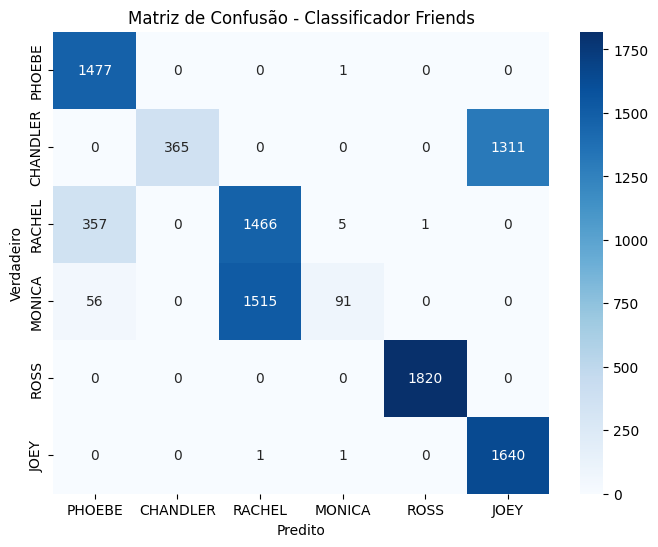

Relatório de Classificação por personagem:
              precision    recall  f1-score   support

      PHOEBE       0.78      1.00      0.88      1478
    CHANDLER       1.00      0.22      0.36      1676
      RACHEL       0.49      0.80      0.61      1829
      MONICA       0.93      0.05      0.10      1662
        ROSS       1.00      1.00      1.00      1820
        JOEY       0.56      1.00      0.71      1642

    accuracy                           0.68     10107
   macro avg       0.79      0.68      0.61     10107
weighted avg       0.79      0.68      0.61     10107



In [ ]:
#gerar a matriz de confusão para entender quais personagens o modelo está confundindo mais

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

best_model = keras.models.load_model("checkpoints/friends_classifier_epoch_04_valacc_0.68.keras")

# Previsões no conjunto de teste
y_pred_probs = best_model.predict(x_test_vect, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Rótulos reais
y_true = y_test.numpy()

# Rótulos dos personagens
id2personagem = {
    0: "PHOEBE",
    1: "CHANDLER",
    2: "RACHEL",
    3: "MONICA",
    4: "ROSS",
    5: "JOEY"
}
labels = list(id2personagem.values())

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Classificador Friends")
plt.show()

# Relatório detalhado
print("Relatório de Classificação por personagem:")
print(classification_report(y_true, y_pred_classes, target_names=labels))

### Ajustes e Treinamentos Adicionais para Melhorar o Desempenho do Classificador

In [ ]:
# ajustar a class_weight para melhorar o desempenho com o classificador

from sklearn.utils import class_weight
import numpy as np

y_train_np = y_train.numpy() if hasattr(y_train, 'numpy') else np.array(y_train)

#Gera pesos balanceados com base nas classes reais de y_train
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

#Transforma em dicionário para passar ao modelo
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Pesos calculados para cada personagem:", class_weight_dict)

Pesos ajustados: {0: np.float64(1.1397958608244516), 1: np.float64(1.004822271936366), 2: np.float64(0.921281735721774), 3: np.float64(1.0134376253509827), 4: np.float64(0.9255850162568119), 5: np.float64(1.0257815671944783)}


In [ ]:
#Treinamento com class_weight

checkpoint_cb = ModelCheckpoint(
    filepath="checkpoints/friends_classifier_epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#Treinamento com os novos pesos
history = classifier_model.fit(
    x_train_vect,
    y_train,
    validation_data=(x_test_vect, y_test),
    batch_size=32,
    epochs=5,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3350 - loss: 1.5905
Epoch 1: val_accuracy improved from -inf to 0.48887, saving model to checkpoints/friends_classifier_epoch_01_valacc_0.49.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3350 - loss: 1.5905 - val_accuracy: 0.4889 - val_loss: 1.2774
Epoch 2/5
1258/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3303 - loss: 1.5916
Epoch 2: val_accuracy improved from 0.48887 to 0.52617, saving model to checkpoints/friends_classifier_epoch_02_valacc_0.53.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3303 - loss: 1.5915 - val_accuracy: 0.5262 - val_loss: 1.1863
Epoch 3/5
1255/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3439 - loss: 1.5788
Epoch 3: val_accuracy improved from 0.52617 to 0.65331, saving model to checkpoints/friends_classifier_epoch_03_valacc_0.65.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3439 - loss: 1.5789 - val_accuracy: 0.6533 - val_loss: 1.

In [ ]:
#Treinar por mais 5 épocas usando os mesmos pesos e callbacks
history_more = classifier_model.fit(
    x_train_vect,
    y_train,
    validation_data=(x_test_vect, y_test),
    batch_size=32,
    epochs=5,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
1249/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3451 - loss: 1.5652
Epoch 1: val_accuracy did not improve from 0.65331
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3451 - loss: 1.5653 - val_accuracy: 0.4897 - val_loss: 1.1870
Epoch 2/5
1251/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3370 - loss: 1.5833
Epoch 2: val_accuracy improved from 0.65331 to 0.80053, saving model to checkpoints/friends_classifier_epoch_02_valacc_0.80.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3370 - loss: 1.5833 - val_accuracy: 0.8005 - val_loss: 1.1762
Epoch 3/5
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3417 - loss: 1.5696
Epoch 3: val_accuracy improved from 0.80053 to 0.85228, saving model to checkpoints/friends_classifier_epoch_03_valacc_0.85.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3417 - loss: 1.5696 - val_accuracy: 0.8523 - val_loss: 1.1632
Epoch 4/5
1247/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3392

In [ ]:
#Congelar menos camadas do BERT para tentar melhorar o desempenho do classificador

#descongela o BERT
pretrained_bert_model.trainable = True

#Recompila o classificador com uma learning rate menor
classifier_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#checkpoint
checkpoint_cb = ModelCheckpoint(
    filepath="checkpoints/friends_finetuned_epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#treinamento
history = classifier_model.fit(
    train_classifier_ds,
    validation_data=test_classifier_ds,
    epochs=5,
    class_weight=class_weight_dict,  # pesos ajustados
    callbacks=[checkpoint_cb]
)

Epoch 1/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7740 - loss: 0.5909
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to checkpoints/friends_finetuned_epoch_01_valacc_1.00.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - accuracy: 0.7741 - loss: 0.5907 - val_accuracy: 1.0000 - val_loss: 0.0164
Epoch 2/5
1261/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0267
Epoch 2: val_accuracy did not improve from 1.00000
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9991 - loss: 0.0267 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 3/5
1259/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0077
Epoch 3: val_accuracy did not improve from 1.00000
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9995 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 8.5550e-04
Epoch 4/5
1259/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0031
Epoch 4: val_accuracy did not improve from 1.00000
1264/12

#### Nova matriz confusão

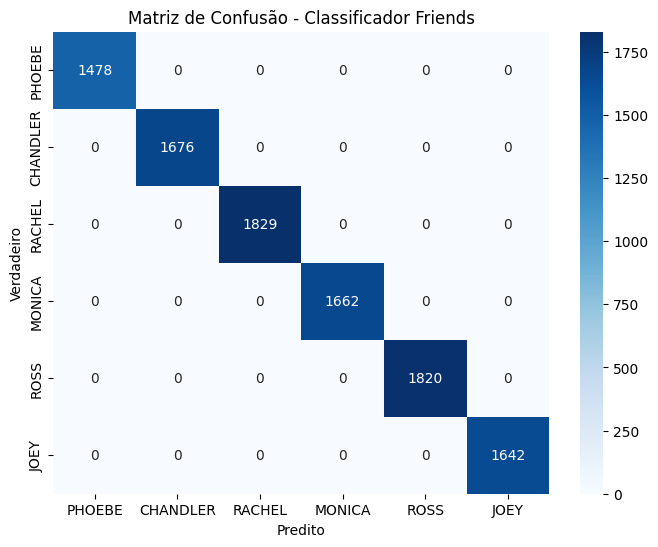

Relatório de Classificação por personagem:

              precision    recall  f1-score   support

      PHOEBE       1.00      1.00      1.00      1478
    CHANDLER       1.00      1.00      1.00      1676
      RACHEL       1.00      1.00      1.00      1829
      MONICA       1.00      1.00      1.00      1662
        ROSS       1.00      1.00      1.00      1820
        JOEY       1.00      1.00      1.00      1642

    accuracy                           1.00     10107
   macro avg       1.00      1.00      1.00     10107
weighted avg       1.00      1.00      1.00     10107



In [ ]:
#Matriz de confusão

best_model = keras.models.load_model("checkpoints/friends_finetuned_epoch_01_valacc_1.00.keras")

y_pred = best_model.predict(x_test_vect, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)


labels = ["PHOEBE", "CHANDLER", "RACHEL", "MONICA", "ROSS", "JOEY"]

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Classificador Friends")
plt.show()

# Relatório de classificação
report = classification_report(y_test, y_pred_classes, target_names=labels)
print("Relatório de Classificação por personagem:\n")
print(report)

### **Refazer o pipeline com oversampling**

In [ ]:
#Recarregar a base de dados falas_tagged

uploaded = files.upload()

with open("falas_tagged.txt", "r", encoding="utf-8") as f:
    falas_tagged = f.read().splitlines()

# Verifica algumas amostras
print(f"Total de falas: {len(falas_tagged)}")
print("Exemplo de fala:", falas_tagged[0])

Saving falas_tagged.txt to falas_tagged.txt
Total de falas: 50531
Exemplo de fala: [PHOEBE] wait, does he eat chalk?


In [ ]:
#Prepara para aplicar o Oversampling

from collections import defaultdict

#Contar falas por personagem
falas_por_personagem = defaultdict(list)

for fala in falas_tagged:
    if fala.startswith("[") and "]" in fala:
        personagem = fala.split("]")[0] + "]"
        falas_por_personagem[personagem].append(fala)

#Exibe contagem atual por personagem
for personagem, falas in falas_por_personagem.items():
    print(f"{personagem}: {len(falas)} falas")

[PHOEBE]: 7389 falas
[CHANDLER]: 8381 falas
[RACHEL]: 9142 falas
[MONICA]: 8310 falas
[ROSS]: 9099 falas
[JOEY]: 8210 falas


In [ ]:
#aplicar o Oversampling
import random

# Encontra o personagem com mais falas
max_falas = max(len(falas) for falas in falas_por_personagem.values())

# Aplica o oversampling
falas_balanceadas = []

for personagem, falas in falas_por_personagem.items():
    if len(falas) < max_falas:
        multiplicado = falas * (max_falas // len(falas))
        resto = random.choices(falas, k=max_falas - len(multiplicado))
        falas_balanceadas.extend(multiplicado + resto)
    else:
        falas_balanceadas.extend(falas)

# Embaralha as falas para evitar agrupamento por personagem
random.shuffle(falas_balanceadas)

print(f"\nTotal de falas balanceadas: {len(falas_balanceadas)}")


Total de falas balanceadas: 54852


In [ ]:
#salva novo ds balanceado
with open("falas_balanceadas.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(falas_balanceadas))

# Download no Colab
from google.colab import files
files.download("falas_balanceadas.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Atualizar a vectorize_layer para a nova bd balanceada

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras

#Custom standardization
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, r"[^\w\s\[\]]", "")

#Cria a camada de vetorização com [MASK]
def get_vectorize_layer(texts, vocab_size=30000, max_seq_length=128, special_tokens=["[MASK]"]):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq_length,
    )

    # Adapta com os textos
    vectorize_layer.adapt(texts)

    # Constrói vocabulário com tokens especiais no início
    vocab = vectorize_layer.get_vocabulary()
    vocab = [tok for tok in vocab if tok not in ["", "[UNK]"] + special_tokens]
    vocab = vocab[:vocab_size - len(special_tokens) - 2]
    vocab_final = ["", "[UNK]"] + special_tokens + vocab

    vectorize_layer.set_vocabulary(vocab_final)
    return vectorize_layer

#Junta as falas balanceadas
falas_balanceadas = [fala for falas in falas_por_personagem.values() for fala in falas]
vectorize_layer = get_vectorize_layer(falas_balanceadas)

# Salva a camada como modelo
vectorize_model = keras.Sequential([vectorize_layer])
vectorize_model(tf.constant(["exemplo de texto"]))
vectorize_model.save("vectorize_layer_friends_balanced.keras")

# Faz download
from google.colab import files
files.download("vectorize_layer_friends_balanced.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Codificar os textos e aplicar o masking para MLM

def encode(texts, vectorize_layer):
    return vectorize_layer(texts).numpy()


def get_masked_input_and_labels(encoded_texts, mask_token_id):
    #Aplica máscara em 15% dos tokens
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    inp_mask[encoded_texts <= 2] = False  # Não aplica em padding, OOV ou [MASK]

    #Cria rótulos com -1 nos tokens que não queremos prever
    y_labels = np.full_like(encoded_texts, fill_value=-1)
    y_labels[inp_mask] = encoded_texts[inp_mask]

    #Copia os tokens para aplicar a máscara
    encoded_texts_masked = np.copy(encoded_texts)

    #90% dos tokens mascarados viram [MASK]
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[inp_mask_2mask] = mask_token_id

    #10% viram tokens aleatórios válidos
    vocab_size = len(vectorize_layer.get_vocabulary())
    inp_mask_2random = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.10)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(3, vocab_size, inp_mask_2random.sum())

    #Define os pesos (só computa o loss onde há token verdadeiro)
    sample_weights = np.where(y_labels != -1, 1.0, 0.0).astype(np.float32)

    return encoded_texts_masked.astype(np.int32), y_labels.astype(np.int32), sample_weights


In [ ]:
#Codifica os textos
x_encoded = encode(falas_balanceadas, vectorize_layer)


vocab = vectorize_layer.get_vocabulary()
id2token = dict(enumerate(vocab))
token2id = {token: idx for idx, token in enumerate(vocab)}
mask_token_id = token2id["[MASK]"]

#masking
x_masked, y_labels, sample_weights = get_masked_input_and_labels(x_encoded, mask_token_id)

In [ ]:
#dataset de treinamento para MLM

BATCH_SIZE = 32

mlm_ds = tf.data.Dataset.from_tensor_slices((x_masked, y_labels, sample_weights))

mlm_ds = mlm_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)

In [ ]:
#BERT
import keras_nlp
from tensorflow import keras
from keras import layers

EMBED_DIM = 128
NUM_HEAD = 4
FF_DIM = 256
NUM_LAYERS = 4
VOCAB_SIZE = 30000
MAX_LEN = 128
LR = 1e-5

#Função de perda e métrica
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
loss_tracker = keras.metrics.Mean(name="loss")

#encoder BERT block
def bert_module(query, key, value, i):
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEAD,
        key_dim=EMBED_DIM // NUM_HEAD,
        name=f"encoder_{i}_multiheadattention"
    )(query, key, value)

    attention_output = layers.Dropout(0.1, name=f"encoder_{i}_att_dropout")(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6, name=f"encoder_{i}_att_layernorm")(query + attention_output)

    ffn = keras.Sequential([
        layers.Dense(FF_DIM, activation="relu"),
        layers.Dense(EMBED_DIM)
    ], name=f"encoder_{i}_ffn")

    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}_ffn_dropout")(ffn_output)
    output = layers.LayerNormalization(epsilon=1e-6, name=f"encoder_{i}_ffn_layernorm")(attention_output + ffn_output)

    return output


class MaskedLanguageModel(keras.Model):
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        #valid_indices = tf.where(y != -1)

        #y_pred = tf.gather_nd(y_pred, valid_indices)
        #y = tf.gather_nd(y, valid_indices)
        #sample_weight = tf.gather_nd(sample_weight, valid_indices)

        loss = loss_fn(y, y_pred)

        if sample_weight is not None:
            loss = loss * sample_weight

        loss_tracker.update_state(loss)
        return tf.reduce_mean(loss)

    def compute_metrics(self, x, y, y_pred, sample_weight):
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input(shape=(MAX_LEN,), dtype="int64", name="input_ids")

    word_embeddings = layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_DIM,
        name="word_embedding"
    )(inputs)

    position_embeddings = keras_nlp.layers.PositionEmbedding(
        sequence_length=MAX_LEN,
        name="position_embedding"
    )(word_embeddings)

    x = word_embeddings + position_embeddings

    for i in range(NUM_LAYERS):
        x = bert_module(x, x, x, i)

    outputs = layers.Dense(VOCAB_SIZE, activation="softmax", name="mlm_cls")(x)

    model = MaskedLanguageModel(inputs, outputs, name="bert_mlm_friends")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))

    return model

# Criar o modelo
mlm_model = create_masked_language_bert_model()
mlm_model.summary()


Model: "bert_mlm_friends"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 128, 128)  │  3,840,000 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, 128, 128)  │     16,384 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 128, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 128, 128)  │     66,048 │ add_27[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_27[0][0],     │
│                     │                   │            │ add_27[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 128, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 128, 128)  │          0 │ add_27[0][0],     │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 128, 128)  │        256 │ add_28[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 128, 128)  │     65,920 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 128, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 128, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 128, 128)  │        256 │ add_29[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_multihea… │ (None, 128, 128)  │     66,048 │ encoder_0_ffn_la… │
│ (MultiHeadAttentio… │                   │            │ encoder_0_ffn_la… │
│                     │                   │            │ encoder_0_ffn_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_att_drop… │ (None, 128, 128)  │          0 │ encoder_1_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 128, 128)  │          0 │ encoder_0_ffn_la… │
│                     │                   │            │ encoder_1_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_att_laye… │ (None, 128, 128)  │        256 │ add_30[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 8,256,304 (31.50 MB)

 Trainable params: 8,256,304 (31.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Salva o modelo ainda não treinado
from google.colab import files


mlm_model.save("bert_mlm_friends_untrained.keras")
files.download("bert_mlm_friends_untrained.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Treinar o modelo BERT-MLM
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath="checkpoints/bert_mlm_best.keras",
    monitor="loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = mlm_model.fit(
    mlm_ds,
    epochs=5,
    callbacks=[checkpoint_cb]
)

mlm_model.save("bert_mlm_friends_trained.keras")
files.download("bert_mlm_friends_trained.keras")
files.download("checkpoints/bert_mlm_best.keras")

Epoch 1/5
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 10.3089
Epoch 1: loss improved from inf to 10.30890, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - loss: 10.3089
Epoch 2/5
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.3053
Epoch 2: loss improved from 10.30890 to 10.29825, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 10.3052
Epoch 3/5
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.2790
Epoch 3: loss improved from 10.29825 to 10.27760, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 10.2790
Epoch 4/5
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.2744
Epoch 4: loss improved from 10.27760 to 10.27423, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 10.2744
Epoch 5/5
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.2711
Epoch 5: loss impro

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Rodar 10 épocas
history = mlm_model.fit(
    mlm_ds,
    epochs=10,
    callbacks=[checkpoint_cb]
)

mlm_model.save("bert_mlm_friends_trained.keras")

Epoch 1/10
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.2631
Epoch 1: loss improved from 10.27047 to 10.26240, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 10.2631
Epoch 2/10
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.2541
Epoch 2: loss improved from 10.26240 to 10.25407, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 10.2541
Epoch 3/10
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.2471
Epoch 3: loss improved from 10.25407 to 10.24644, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 10.2471
Epoch 4/10
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.2413
Epoch 4: loss improved from 10.24644 to 10.23969, saving model to checkpoints/bert_mlm_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 10.2413
Epoch 5/10
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.2364
Epoch 5: 

In [ ]:
#Rodar 5 épocas
history = mlm_model.fit(
    mlm_ds,
    epochs=5,
    callbacks=[checkpoint_cb]
)

mlm_model.save("bert_mlm_friends_trained.keras")

Epoch 1/5
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 10.2234
Epoch 1: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 10.2235
Epoch 2/5
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2259
Epoch 2: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 10.2260
Epoch 3/5
  81/1580 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 10.2631

KeyboardInterrupt: 

In [ ]:
#treinar com LR = 1e-6 para tentar diminuir o loss
mlm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6))

history = mlm_model.fit(
    mlm_ds,
    epochs=5,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.2597
Epoch 1: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 65s 24ms/step - loss: 10.2597
Epoch 2/5
1578/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2593
Epoch 2: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 10.2593
Epoch 3/5
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2590
Epoch 3: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 10.2590
Epoch 4/5
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2594
Epoch 4: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 10.2594
Epoch 5/5
1579/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2590
Epoch 5: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 10.2590


In [ ]:
#Recompilar o seu modelo para aplicar a nova função de perda corrigida
mlm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6))

history = mlm_model.fit(
    mlm_ds,
    epochs=5,
    callbacks=[checkpoint_cb]
)



Epoch 1/5
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.2591
Epoch 1: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 66s 24ms/step - loss: 10.2591
Epoch 2/5
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 10.2588
Epoch 2: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 10.2588
Epoch 3/5
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 10.2589
Epoch 3: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 10.2589
Epoch 4/5
1578/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 10.2588
Epoch 4: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 10.2588
Epoch 5/5
1577/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2588
Epoch 5: loss did not improve from 10.22130
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 10.2587


### Diagnóstico dos dados mascarados - inspecionar possíveis problemas nas entradas:

In [ ]:
import numpy as np

# Verifica quantas amostras têm apenas padding ou valores irrelevantes
apenas_zeros = np.all(x_masked == 0, axis=1)
so_mask = np.all((x_masked == mask_token_id) | (x_masked == 0), axis=1)
nenhuma_label = np.all(y_labels == -1, axis=1)

print("Amostras com apenas zeros:", apenas_zeros.sum())
print("Amostras com apenas [MASK] e padding:", so_mask.sum())
print("Amostras sem nenhum rótulo válido:", nenhuma_label.sum())

Amostras com apenas zeros: 0
Amostras com apenas [MASK] e padding: 105
Amostras sem nenhum rótulo válido: 15485


In [ ]:
#Filtrar amostras inválidas

# Máscara para filtrar amostras úteis (aquelas que têm ao menos um rótulo válido)
validas = np.any(y_labels != -1, axis=1)

# Aplica o filtro
x_masked = x_masked[validas]
y_labels = y_labels[validas]
sample_weights = sample_weights[validas]

# Mostra nova dimensão do dataset
print("Novo shape de x_masked:", x_masked.shape)

Novo shape de x_masked: (35046, 128)


In [ ]:
#Recriar o dataset mlm_ds
BATCH_SIZE = 32
mlm_ds = tf.data.Dataset.from_tensor_slices((x_masked, y_labels, sample_weights))
mlm_ds = mlm_ds.shuffle(1000).batch(BATCH_SIZE)

In [ ]:
#Novo treinamento
mlm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

checkpoint_cb = ModelCheckpoint(
    filepath="checkpoints/bert_mlm_filtered_best.keras",
    monitor="loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Treinamento
history = mlm_model.fit(
    mlm_ds,
    epochs=5,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.2166
Epoch 1: loss improved from inf to 10.22743, saving model to checkpoints/bert_mlm_filtered_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 66s 24ms/step - loss: 10.2166
Epoch 2/5
1578/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2454
Epoch 2: loss did not improve from 10.22743
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 10.2454
Epoch 3/5
1578/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2235
Epoch 3: loss did not improve from 10.22743
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 10.2235
Epoch 4/5
1578/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2489
Epoch 4: loss did not improve from 10.22743
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 10.2489
Epoch 5/5
1579/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2367
Epoch 5: loss did not improve from 10.22743
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 10.2367


## 🍀 **BERT Model** (nova versão)

Prof, desistimos. Vamos refazer o projeto do começo =(

Novo projeto. Objetivo: Treinar um modelo BERT (do zero ou com fine-tuning) para completar frases dos personagens de Friends

Etapas:
1. Dataset | Organizar as falas dos personagens de Friends em formato linha por linha
2. Pré-processamento | Limpeza básica
3. Tokenização
4. Dataset para treino | Criar Dataset com frases mascaradas ([MASK]) no estilo MLM.
5. Modelo BERT
6. Treinamento | Treinar com callbacks de checkpoint e salvar o modelo.
7. Avaliação/Testes | Completar frases manualmente com o modelo e ver os resultados.


### Dependências

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "torch"  # or jax, or tensorflow

import keras_hub

import keras
from keras import layers
from keras.layers import TextVectorization

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

In [ ]:
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

### 1 Carregar Dataset

In [ ]:
#Recarregar a base de dados com os .txt dos 6 personagens
from google.colab import files
from collections import defaultdict
import pandas as pd


uploaded = files.upload()

# Dicionário arquivos - personagens
files = {
    "Chandler": "falas_chandler.txt",
    "Joey": "falas_joey.txt",
    "Monica": "falas_monica.txt",
    "Phoebe": "falas_phoebe.txt",
    "Rachel": "falas_rachel.txt",
    "Ross": "falas_ross.txt",
}

#Lista para armazenar
all_lines = []

#Leitura dos arquivos
for character, filename in files.items():
    with open(filename, "r", encoding="utf-8") as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        all_lines.extend([(character, line) for line in lines])

#DataFrame
df_friends = pd.DataFrame(all_lines, columns=["character", "line"])


print(df_friends.sample(5))
print(f"\nTotal de falas carregadas: {len(df_friends)}")
print(df_friends['character'].value_counts())

Saving falas_chandler.txt to falas_chandler (1).txt
Saving falas_joey.txt to falas_joey (1).txt
Saving falas_monica.txt to falas_monica (1).txt
Saving falas_phoebe.txt to falas_phoebe (1).txt
Saving falas_rachel.txt to falas_rachel (1).txt
Saving falas_ross.txt to falas_ross (1).txt
      character                                               line
6125   Chandler  Well y'know a lot of those Muppets don't have ...
51332    Rachel                                               Why?
52679    Rachel                                            Pheebs?
17203      Joey                      That guy’s still doing that?!
65311      Ross                                               Ohh…

Total de falas carregadas: 65621
character
Rachel      11899
Ross        11842
Monica      10937
Chandler    10858
Joey        10545
Phoebe       9540
Name: count, dtype: int64


### 2 Pré-processamento e Limpeza dos Dados

In [ ]:
import re

def limpar_fala(fala):
    #Remover colchetes e parênteses
    fala = re.sub(r'\[.*?\]', '', fala)
    fala = re.sub(r'\(.*?\)', '', fala)

    #Remover pontuação
    fala = re.sub(r"[^\w\s']", '', fala)

    #Remover espaços nas extremidades
    fala = fala.strip()

    return fala

df_friends["clean_line"] = df_friends["line"].apply(limpar_fala)

#Remover falas muito curtas
df_friends = df_friends[df_friends["clean_line"].str.split().str.len() >= 4]

print(df_friends.sample(5))
print(f"\nTotal de falas após limpeza: {len(df_friends)}")


      character                                               line  \
24369    Monica          Have I read it?  No, are you enjoying it?   
53839      Ross  Well, we just wanted to say a quick hi, and th...   
937    Chandler                           Uh Kathy, with K or a C?   
51080    Rachel  You know what, I can't do this. I don't know w...   
38972    Phoebe  No! But it's the nicest kitchen, the refrigera...   

                                              clean_line  
24369             Have I read it  No are you enjoying it  
53839  Well we just wanted to say a quick hi and then...  
937                               Uh Kathy with K or a C  
51080  You know what I can't do this I don't know whi...  
38972  No But it's the nicest kitchen the refrigerato...  

Total de falas após limpeza: 47813


In [ ]:
#Separa treino e teste
from sklearn.model_selection import train_test_split

train_lines, test_lines = train_test_split(
    df_friends["clean_line"], test_size=0.1, random_state=42
)

train_df = pd.DataFrame({"line": train_lines})
test_df = pd.DataFrame({"line": test_lines})
all_data = pd.concat([train_df, test_df], ignore_index=True)

# Visualizar
print(f"Total de falas limpas: {len(all_data)}")
print(f"Treino: {len(train_df)} | Teste: {len(test_df)}")

Total de falas limpas: 47813
Treino: 43031 | Teste: 4782


### 3 Preparando dados para o Treinamento com MLM

In [ ]:
#preparar os dados pro treinamento com Masked Language Modeling (MLM)

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization



def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=max_seq,
        standardize=custom_standardization
    )
    vectorize_layer.adapt(texts)

    # Adiciona token [MASK] vocabulário
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)

    return vectorize_layer


In [ ]:
#instanciar vectorize_layer
vectorize_layer = get_vectorize_layer(
    all_data.line.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"]
)

In [ ]:
# Pega o id do token [MASK]
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]

In [ ]:
def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

In [ ]:
def get_masked_input_and_labels(encoded_texts, mask_token_id):
    # 15% das posições serão consideradas para masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15

    # Evita mascarar tokens especiais (0 = PAD, 1 = UNK, 2 = START)
    inp_mask[encoded_texts <= 2] = False

    # Labels: -1 onde não há máscara (ignorar na loss)
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    labels[inp_mask] = encoded_texts[inp_mask]

    # Cria cópia para modificar as entradas mascaradas
    encoded_texts_masked = np.copy(encoded_texts)

    # 90% dos tokens mascarados viram [MASK]
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.9)
    encoded_texts_masked[inp_mask_2mask] = mask_token_id

    # 10% dos tokens mascarados viram tokens aleatórios
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Sample weights: 1 onde há máscara, 0 onde não há
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    return encoded_texts_masked, encoded_texts, sample_weights

In [ ]:
#preparar os dados para Masked Language Modeling
x_all = encode(all_data.line.values)

x_masked, y_labels, sample_weights = get_masked_input_and_labels(x_all, mask_token_id)

In [ ]:
#preparar os dados para Masked Language Modeling
mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked, y_labels, sample_weights)
)

mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

### 5 Modelagem BERT


In [ ]:
#Criando o BERT model
import keras_nlp


def bert_module(query, key, value, i):
    # Multi-headed Self-Attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name=f"encoder_{i}_multiheadattention"
    )(query, key, value)

    # Dropout + Residual Connection + Layer Norm
    attention_output = layers.Dropout(0.1, name=f"encoder_{i}_att_dropout")(attention_output)
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}_att_layernormalization"
    )(query + attention_output)

    # Feed Forward Network (FFN)
    ffn = keras.Sequential([
        layers.Dense(config.FF_DIM, activation="relu"),
        layers.Dense(config.EMBED_DIM),
    ], name=f"encoder_{i}_ffn")

    ffn_output = ffn(attention_output)

    # Dropout + Residual Connection + Layer Norm
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}_ffn_dropout")(ffn_output)
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}_ffn_layernormalization"
    )(attention_output + ffn_output)

    return sequence_output


In [ ]:
#definição da função de loss e o método de rastreamento
loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction=None)
loss_tracker = keras.metrics.Mean(name="loss")


In [ ]:
class MaskedLanguageModel(keras.Model):

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        loss = loss_fn(y, y_pred, sample_weight)
        loss_tracker.update_state(loss, sample_weight=sample_weight)
        return keras.ops.sum(loss)

    def compute_metrics(self, x, y, y_pred, sample_weight):
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE,
        config.EMBED_DIM,
        name="word_embedding"
    )(inputs)


    position_embeddings = keras_nlp.layers.PositionEmbedding(
        sequence_length=config.MAX_LEN
    )(word_embeddings)


    embeddings = word_embeddings + position_embeddings


    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(
            encoder_output, encoder_output, encoder_output, i
        )


    mlm_output = layers.Dense(
        config.VOCAB_SIZE, activation="softmax", name="mlm_cls"
    )(encoder_output)

    #Modelo final
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    #Compila com otimizador Adam e learning rate da config
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)

    return mlm_model


In [ ]:
#classe MaskedTextGenerator pra ser usada como callback durante o treino

import numpy as np
from pprint import pprint
from tensorflow import keras

class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]  # ignorar batch dim
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k:][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(self.sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)

In [ ]:
sample_tokens = vectorize_layer(["Joey doesn't share [mask]!"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

In [ ]:
#Instancia o modelo
bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 256, 128)  │  3,840,000 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, 256, 128)  │     32,768 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 256, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 256, 128)  │     66,048 │ add_39[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_39[0][0],     │
│                     │                   │            │ add_39[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 256, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 256, 128)  │          0 │ add_39[0][0],     │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 256, 128)  │        256 │ add_40[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 256, 128)  │     33,024 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 256, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 256, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 256, 128)  │        256 │ add_41[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_cls (Dense)     │ (None, 256,       │  3,870,000 │ encoder_0_ffn_la… │
│                     │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,842,352 (29.92 MB)

 Trainable params: 7,842,352 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Salvar o modelo
bert_masked_model.save("bert_mlm_friends.keras")
from google.colab import files
files.download("bert_mlm_friends.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 6 Realizar Treinamento do Modelo

In [ ]:
import os

checkpoint_dir = "checkpoints_friends"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "bert_mlm_best.keras"),
    monitor="loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

bert_masked_model.fit(
    mlm_ds,
    epochs=5,
    callbacks=[generator_callback, checkpoint_cb]
)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('i'),
 'prediction': 'going ii iim i',
 'probability': np.float32(0.040982)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('you'),
 'prediction': 'going ii iim you',
 'probability': np.float32(0.024867315)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('to'),
 'prediction': 'going ii iim to',
 'probability': np.float32(0.023333289)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('the'),
 'prediction': 'going ii iim the',
 'probability': np.float32(0.023098402)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('[rachel]'),
 'prediction': 'going ii iim [rachel]',
 'probability': np.float32(0.0139482645)}

Epoch 1: loss improved from inf to 6.40247, saving model to checkpoints_friends/bert_mlm_best.keras
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 37s 17m

In [ ]:
#rodar mais 2
bert_masked_model.fit(
    mlm_ds,
    epochs=7,  # continua até a época 7
    initial_epoch=5,  # começa da época 5
    callbacks=[generator_callback, checkpoint_cb]
)

Epoch 6/7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('this'),
 'prediction': 'going ii iim this',
 'probability': np.float32(0.6719368)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('is'),
 'prediction': 'going ii iim is',
 'probability': np.float32(0.042136025)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('you'),
 'prediction': 'going ii iim you',
 'probability': np.float32(0.037505284)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('mom'),
 'prediction': 'going ii iim mom',
 'probability': np.float32(0.023680525)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('harder'),
 'prediction': 'going ii iim harder',
 'probability': np.float32(0.02169537)}

Epoch 6: loss improved from 3.62856 to 3.06527, saving model to checkpoints_friends/bert_mlm_best.keras
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 19s

In [ ]:
#rodar mais 2
bert_masked_model.fit(
    mlm_ds,
    epochs=10,  # continua até a época 7
    initial_epoch=7,  # começa da época 5
    callbacks=[generator_callback, checkpoint_cb]
)

Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('this'),
 'prediction': 'going ii iim this',
 'probability': np.float32(0.40503013)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('seen'),
 'prediction': 'going ii iim seen',
 'probability': np.float32(0.17932491)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('harder'),
 'prediction': 'going ii iim harder',
 'probability': np.float32(0.087055266)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('you'),
 'prediction': 'going ii iim you',
 'probability': np.float32(0.05066796)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('7'),
 'prediction': 'going ii iim 7',
 'probability': np.float32(0.030557258)}

Epoch 8: loss improved from 2.56675 to 2.16814, saving model to checkpoints_friends/bert_mlm_best.keras
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
#rodar mais 2
bert_masked_model.fit(
    mlm_ds,
    epochs=12,  # continua até a época 7
    initial_epoch=10,  # começa da época 5
    callbacks=[generator_callback, checkpoint_cb]
)

Epoch 11/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('this'),
 'prediction': 'going ii iim this',
 'probability': np.float32(0.64479685)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('seen'),
 'prediction': 'going ii iim seen',
 'probability': np.float32(0.11941394)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('im'),
 'prediction': 'going ii iim im',
 'probability': np.float32(0.04871526)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('you'),
 'prediction': 'going ii iim you',
 'probability': np.float32(0.04315217)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('ursula'),
 'prediction': 'going ii iim ursula',
 'probability': np.float32(0.023290662)}

Epoch 11: loss improved from 1.65084 to 1.48229, saving model to checkpoints_friends/bert_mlm_best.keras
1495/1495 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
#rodar mais 2
bert_masked_model.fit(
    mlm_ds,
    epochs=15,  # continua até a época 7
    initial_epoch=12,  # começa da época 5
    callbacks=[generator_callback, checkpoint_cb]
)

Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('this'),
 'prediction': 'going ii iim this',
 'probability': np.float32(0.7591521)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('seen'),
 'prediction': 'going ii iim seen',
 'probability': np.float32(0.11133392)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('you'),
 'prediction': 'going ii iim you',
 'probability': np.float32(0.060507078)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('im'),
 'prediction': 'going ii iim im',
 'probability': np.float32(0.018963253)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('exactly'),
 'prediction': 'going ii iim exactly',
 'probability': np.float32(0.00856397)}

Epoch 13: loss improved from 1.33854 to 1.21694, saving model to checkpoints_friends/bert_mlm_best.keras
1495/1495 ━━━━━━━━━━━━━━━━━━

In [ ]:
#rodar mais 2
bert_masked_model.fit(
    mlm_ds,
    epochs=17,  # continua até a época 7
    initial_epoch=15,  # começa da época 5
    callbacks=[generator_callback, checkpoint_cb]
)

Epoch 16/17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('this'),
 'prediction': 'going ii iim this',
 'probability': np.float32(0.7054083)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('isnt'),
 'prediction': 'going ii iim isnt',
 'probability': np.float32(0.07002288)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('seen'),
 'prediction': 'going ii iim seen',
 'probability': np.float32(0.059161764)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('7'),
 'prediction': 'going ii iim 7',
 'probability': np.float32(0.030903662)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('ago'),
 'prediction': 'going ii iim ago',
 'probability': np.float32(0.017364075)}

Epoch 16: loss improved from 1.02732 to 0.94614, saving model to checkpoints_friends/bert_mlm_best.keras
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 19s 

In [ ]:
bert_masked_model.save("bert_mlm_friends_final.keras")
from google.colab import files
files.download("bert_mlm_friends_final.keras")
files.download("checkpoints_friends/bert_mlm_best.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Fine-tune - completar frases ao estilo Friends

In [ ]:
from tensorflow import keras

# Carrega o modelo salvo com MLM
mlm_model = keras.models.load_model(
    "bert_mlm_friends_final.keras",
    custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)

In [ ]:
#Extrair apenas o encoder
pretrained_bert_model = keras.Model(
    mlm_model.input,
    mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

In [ ]:
#Congelar o encoder
pretrained_bert_model.trainable = False

In [ ]:
#Refinar o treinamento
mlm_model.fit(
    mlm_ds,
    epochs=20,               # ex: vamos até a época 20
    initial_epoch=17,        # porque você já treinou até a 17
    callbacks=[generator_callback, checkpoint_cb]
)

Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('ursula'),
 'prediction': 'going ii iim ursula',
 'probability': np.float32(0.30931404)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('this'),
 'prediction': 'going ii iim this',
 'probability': np.float32(0.20557728)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('isnt'),
 'prediction': 'going ii iim isnt',
 'probability': np.float32(0.09847512)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('is'),
 'prediction': 'going ii iim is',
 'probability': np.float32(0.034164406)}
{'input_text': 'going ii iim communicating',
 'predicted mask token': np.str_('grab'),
 'prediction': 'going ii iim grab',
 'probability': np.float32(0.033887226)}

Epoch 18: loss improved from 0.88186 to 0.76170, saving model to checkpoints_friends/bert_mlm_best.keras
1495/1495 ━━━━━━━━━━━━━━━━━━━

In [ ]:
bert_masked_model.save("bert_mlm_friends_final.keras")
from google.colab import files
files.download("bert_mlm_friends_final.keras")
files.download("checkpoints_friends/bert_mlm_best.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 7 Avaliação do Modelo e Realização de Testes

In [ ]:
#testar várias frases com [MASK] e ver o modelo treinado completa cada uma

def completar_frases_friends(frases_com_mask, top_k=5):
    for frase in frases_com_mask:
        print(f"\nInput: {frase}")

        sample_tokens = vectorize_layer([frase]).numpy()
        prediction = mlm_model.predict(sample_tokens)

        masked_index = np.where(sample_tokens == mask_token_id)[1]
        mask_prediction = prediction[0][masked_index]

        #Top-K predições
        top_indices = mask_prediction[0].argsort()[-top_k:][::-1]
        for i in range(top_k):
            predicted_token_id = top_indices[i]
            probability = mask_prediction[0][predicted_token_id]

            completado = np.copy(sample_tokens[0])
            completado[masked_index[0]] = predicted_token_id
            frase_completada = " ".join([id2token[t] for t in completado if t != 0])

            print(f"  {i+1}. {frase_completada}  (prob: {probability:.4f})")

In [ ]:
frases = [
    "Joey doesn't share [mask]!",
    "How you [mask]?",
    "Could I *be* wearing any more [mask]?",
    "Welcome to the real [mask]!",
    "I got off the [mask]!",
    "Smelly [mask], smelly [mask], what are they feeding you?"
]

completar_frases_friends(frases)


Input: Joey doesn't share [mask]!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
  1. going ii iim isnt  (prob: 0.3771)
  2. going ii iim this  (prob: 0.2907)
  3. going ii iim boxes  (prob: 0.1287)
  4. going ii iim ursula  (prob: 0.0299)
  5. going ii iim herself  (prob: 0.0197)

Input: How you [mask]?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
  1. think i between  (prob: 0.0835)
  2. think i your  (prob: 0.0660)
  3. think i gonna  (prob: 0.0607)
  4. think i no  (prob: 0.0605)
  5. think i check  (prob: 0.0535)

Input: Could I *be* wearing any more [mask]?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
  1. hi [MASK] dont must has believe wanted  (prob: 0.8053)
  2. hi [MASK] dont must has believe he  (prob: 0.0578)
  3. hi [MASK] dont must has believe [sees  (prob: 0.0508)
  4. hi [MASK] dont must has believe ten  (prob: 0.0155)
  5. hi [MASK] dont must has believe then  (prob: 0.0155)

Input: Welcome to the real [mask]!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
  1. forever the you year maid  (prob: 0.98

## 🌦️ Implementação do Modelo Oculto de Markov

### Dependências

In [ ]:
import pandas as pd
import re
from collections import defaultdict, Counter


### Carregamento da Base de Dados

In [ ]:
#Upload dos arquivos
from google.colab import files
uploaded = files.upload()

Saving falas_chandler.txt to falas_chandler.txt
Saving falas_joey.txt to falas_joey.txt
Saving falas_monica.txt to falas_monica.txt
Saving falas_phoebe.txt to falas_phoebe.txt
Saving falas_rachel.txt to falas_rachel.txt
Saving falas_ross.txt to falas_ross.txt


### Limpeza dos Dados
Nesta estapa realizamos para cada fala carregada de todos os personagens:
* Remoção de texto entre colchetes, parenteses;
* Remoção de todos os caracteres, exceto letras, números, espaços e apóstrofos, garantindo que apenas texto limpo e legível permaneça;
* Subtituição de várias espaços em branco por apenas um único espaço em branco;
* Remoção de espaços iniciais/finais;
* Converção do texto para minúsculas.

In [ ]:
#Ler e limpar os dados
arquivos = [
    "falas_joey.txt", "falas_chandler.txt", "falas_rachel.txt",
    "falas_monica.txt", "falas_phoebe.txt", "falas_ross.txt"
]

def limpar_fala(fala):
    fala = re.sub(r'\[.*?\]', '', fala)
    fala = re.sub(r'\(.*?\)', '', fala)
    fala = re.sub(r"[^\w\s']", '', fala)
    fala = re.sub(r'\s+', ' ', fala)
    return fala.strip().lower()

falas = []
for arquivo in arquivos:
    with open(arquivo, "r", encoding="utf-8") as f:
        for linha in f:
            limpa = limpar_fala(linha)
            if len(limpa.split()) >= 4:
                falas.append(limpa)

### Construção do Triagramas

Realizamos a definição de um n-grams de 3 elementos para encontrar um padrõa linguíticos nas falas (ou seja, nosso _corpus_). Desta forma, definimos como podemos encontrar a próxima sequência dada uma sequência de 2 palavras (probabilidade condicional).

Então, definimos a frequência para cada par de palavras (chave) contamos quantas vezes cada palavra apareceu depois (utilizando Counter).


In [ ]:
#Construir os trigramas
from collections import defaultdict, Counter

trigramas = defaultdict(list)
for frase in falas:
    tokens = frase.split()
    for i in range(len(tokens) - 2):
        chave = (tokens[i], tokens[i+1])
        prox = tokens[i+2]
        trigramas[chave].append(prox)

# Frequências
modelo_markov = {chave: Counter(palavras) for chave, palavras in trigramas.items()}

### Modelagem do Modelo Oculto de Markov com Máscara

Na última etapa criamos o método para completar as frases, onde dada uma frase com uma lacuna (representado por ` ____ `), o algoritmo tenta preencher com a palavra mais provável (novamente, baseando-se nas duas palavras anteriores à lacuna).

In [ ]:
#Função para completar frases

def completar_frase_markov(frase, placeholder="___"):
    frase = frase.replace("'___'", "___").replace('"___"', "___")  # normaliza
    tokens = frase.lower().split()

    if "___" not in tokens:
        return "A frase precisa conter '___'"

    idx = tokens.index("___")
    if idx < 2:
        return "São necessárias 2 palavras antes da lacuna."

    contexto = (tokens[idx - 2], tokens[idx - 1])
    if contexto not in modelo_markov:
        return "Contexto não encontrado no modelo."

    palavra = modelo_markov[contexto].most_common(1)[0][0]
    tokens[idx] = palavra
    return " ".join(tokens)

### Testando a previsibilidade do modelo

Agora podemos testar com um conjunto de frases e que podem ser completadas.

In [ ]:
#Testando o modelo
frases_teste = [
    "Joey doesn't share ___ !",
    "How you ___ ?",
    "I got off the ___ !",
    "Could I be wearing any more ___ ?"
]

for frase in frases_teste:
    print(f"\nFrase original: {frase}")
    print("Frase completada:", completar_frase_markov(frase))


Frase original: Joey doesn't share ___ !
Frase completada: joey doesn't share food !

Frase original: How you ___ ?
Frase completada: how you doin ?

Frase original: I got off the ___ !
Frase completada: i got off the plane !

Frase original: Could I be wearing any more ___ ?
Frase completada: could i be wearing any more clothes ?




---



# **Comparação e análise dos resultados**

A implementação de ambos os modelos (BERT e HMM) mostram-se um desafio por algumas questões: tratar corretamente a base de dados para treiná-los corretamente (ou da melhor forma possível) para atingir o objetivo, mesmo que haja uma boa quantidade de dados para cada um dos 6 personagens principais da série; e pelo própria instigação de se implementar esses modelos.

Trantando da implementação do modelo de BERT, realizamos duas implementações sendo a primeira com muitos problemas e a segunda como uma tentativa de realizar melhorias. Focando na primeira implementação, houve muito esforço no tratamento dos dados e na etapa de treinamento, pois os resultados obtidos após o treinamento não foram satisfatórios. A solução foi adicionar pesos, mas que mesmo assim gerou um overffiting. Numa outra tentativa (nesta mesma primeira implementação), foram feitos outros ajustes para obtermos um oversampling.

No fim das contas, optamos por realizar uma segunda implementação do modelo de BERT ainda que com resultados não muito bons.

Por outro lado, na implementação do Modelo Oculto de Markov, utilizamos uma abordagem mais simples porque simula apenas o componente de emissão de um HMM sem modelar explicitamente os estados ocultos.

Em vez de usar bibliotecas como hmmlearn, que exigem a definição e o treinamento de uma estrutura completa com estados e probabilidades, ela utiliza trigramas para prever observações diretamente com base no contexto anterior. Foi uma abordagem mais leve devido a carga que tivemos na implementação do modelo de BERT.

E ainda, com a simplicidade, conseguimos atingir o objetivo de completar as frases e ver que elas tem bastante sentido e que condizem com os diálogos dos roteiros originais da série.

Concluímos que podemos meelhorar a modelagem do modelo BERT com a adição de mais planejamento e melhor tratamento da base de dados.  

# Carregar modelo e classificador para apresentação

## BERT

In [ ]:
from google.colab import files
files.download("bert_mlm_friends_final.keras")
files.download("vectorize_layer_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
frases = [
    "Joey doesnt share [mask]!",
    "How you [mask]?",
    "Could I *be* wearing any more [mask]?",
    "Welcome to the real [mask]!",
    "I got off the [mask]"
]

In [ ]:
#Hiperparâmetros
EMBED_DIM = 128
NUM_HEAD = 4
FF_DIM = 256
NUM_LAYERS = 4
VOCAB_SIZE = 30000
MAX_LEN = 128
LR = 1e-4


#criação da vectorize_layer
def get_vectorize_layer(texts, vocab_size=30000, max_seq_length=128, special_tokens=["[MASK]"]):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq_length,
    )
    vectorize_layer.adapt(texts)

    # Ajuste do vocabulário
    vocab = vectorize_layer.get_vocabulary()
    vocab = [tok for tok in vocab if tok not in ["", "[UNK]"] + special_tokens]
    vocab = vocab[:vocab_size - len(special_tokens) - 2]
    vocab_final = ["", "[UNK]"] + special_tokens + vocab
    vectorize_layer.set_vocabulary(vocab_final)

    # Envolve em um modelo Keras e salva
    vectorize_model = keras.Sequential([vectorize_layer])
    vectorize_model(tf.constant(["exemplo de frase"]))  # força a construção

    path = "vectorize_layer_model.keras"
    vectorize_model.save(path)
    #files.download(path)

    return vectorize_layer

#instanciar vectorize_layer
vectorize_layer = get_vectorize_layer(
    all_data.line.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"]
)

#testar várias frases com [MASK] e ver o modelo treinado completa cada uma
def completar_frases_friends(frases_com_mask, top_k=5):
    for frase in frases_com_mask:
        print(f"\nInput: {frase}")

        sample_tokens = vectorize_layer([frase]).numpy()
        prediction = mlm_model.predict(sample_tokens)

        masked_index = np.where(sample_tokens == mask_token_id)[1]
        mask_prediction = prediction[0][masked_index]

        #Top-K predições
        top_indices = mask_prediction[0].argsort()[-top_k:][::-1]
        for i in range(top_k):
            predicted_token_id = top_indices[i]
            probability = mask_prediction[0][predicted_token_id]

            completado = np.copy(sample_tokens[0])
            completado[masked_index[0]] = predicted_token_id
            frase_completada = " ".join([id2token[t] for t in completado if t != 0])

            print(f"  {i+1}. {frase_completada}  (prob: {probability:.4f})")

completar_frases_friends(frases)

ValueError: Invalid dtype: object

## Markov